In [161]:
import json
import numpy as np
import pandas as pd
import torch
import torchaudio
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from typing import Dict, List, Tuple
from collections import defaultdict
from datasets import load_dataset
from tqdm import tqdm

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## 1. Load Custom Concept Dataset

In [162]:
# Load concept-to-tags mapping
CONCEPTS = json.load(open("../data/concepts_to_tags.json", "r"))

print("Available concept categories:")
for cat, tags in CONCEPTS.items():
    print(f"  {cat}: {len(tags)} tags (e.g., {tags[:3]})")

Available concept categories:
  tempo: 50 tags (e.g., ['medium tempo', 'slow tempo', 'fast tempo'])
  genre: 50 tags (e.g., ['rock', 'pop', 'electronic music'])
  mood: 50 tags (e.g., ['emotional', 'passionate', 'energetic'])
  instrument: 50 tags (e.g., ['acoustic drums', 'electric guitar', 'bass guitar'])


In [163]:
# Create reverse mapping
TAG_TO_CATEGORY = {}
for cat, tags in CONCEPTS.items():
    for tag in tags:
        TAG_TO_CATEGORY[tag] = cat

In [164]:
def preprocess_audio(audio_array: np.ndarray, sr: int, target_sr: int = 16000, duration: float = 3.0) -> torch.Tensor:
    """Preprocess audio to fixed length and sample rate."""
    # Resample if needed
    if sr != target_sr:
        audio_array = librosa.resample(audio_array, orig_sr=sr, target_sr=target_sr)
    
    # Trim or pad to fixed duration
    target_length = int(target_sr * duration)
    if len(audio_array) > target_length:
        audio_array = audio_array[:target_length]
    else:
        audio_array = np.pad(audio_array, (0, target_length - len(audio_array)))
    
    return torch.from_numpy(audio_array).float()

In [165]:
# Load GTZAN dataset from local folder
print("Loading GTZAN dataset from local files...")
GTZAN_PATH = Path("../outputs/tta/GTZAN/Data/genres_original")

# Map genre names
GENRE_MAP = {
    'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4,
    'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9
}
TARGET_GENRES = list(GENRE_MAP.keys())

# Load all audio files
print("Scanning audio files...")
audio_files = []
for genre in TARGET_GENRES:
    genre_path = GTZAN_PATH / genre
    wav_files = sorted(genre_path.glob("*.wav"))
    for wav_file in wav_files:
        audio_files.append({
            'path': wav_file,
            'genre': genre,
            'label': GENRE_MAP[genre]
        })

print(f"Loaded {len(audio_files)} audio files")
print(f"Genres: {TARGET_GENRES}")
print(f"Files per genre: ~{len(audio_files) // len(TARGET_GENRES)}")

Loading GTZAN dataset from local files...
Scanning audio files...
Loaded 1000 audio files
Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Files per genre: ~100


In [166]:
# Load and preprocess all GTZAN audio
print("Loading and preprocessing GTZAN audio files...")
X_train, y_train = [], []

for file_info in tqdm(audio_files, desc="Loading audio"):
    # Load audio using librosa
    try:
        audio, sr = librosa.load(file_info['path'], sr=None, mono=True)
    except Exception as e:
        print(f"Error loading {file_info['path']}: {e}")
        continue
    
    # Preprocess audio
    audio_tensor = preprocess_audio(audio, sr)
    X_train.append(audio_tensor)
    y_train.append(file_info['label'])

X_train = torch.stack(X_train)
y_train = torch.tensor(y_train)

print(f"Training data shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")
print(f"Sample rate: 16000 Hz, Duration: 3.0 seconds")

Loading and preprocessing GTZAN audio files...


Loading audio:  55%|█████▍    | 545/1000 [00:04<00:03, 119.86it/s]/tmp/ipykernel_87048/3400546144.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_info['path'], sr=None, mono=True)
/home/bruno/miniconda3/envs/music-gen-interpretability/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Loading audio:  57%|█████▋    | 572/1000 [00:04<00:03, 123.12it/s]

Error loading ../outputs/tta/GTZAN/Data/genres_original/jazz/jazz.00054.wav: 


Loading audio: 100%|██████████| 1000/1000 [00:08<00:00, 121.43it/s]

Training data shape: torch.Size([999, 48000])
Labels shape: torch.Size([999])
Sample rate: 16000 Hz, Duration: 3.0 seconds


## 2. Load GTZAN Dataset and Train Classifier

In [167]:
class MusicGenreClassifier(pl.LightningModule):
    """Simple CNN-based music genre classifier."""
    
    def __init__(self, num_genres: int = 10, lr: float = 0.001):
        super().__init__()
        self.save_hyperparameters()
        
        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000, n_fft=400, hop_length=160, n_mels=64
        )
        
        # CNN feature extractor
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Bottleneck layer (for TCAV)
        self.bottleneck = torch.nn.Linear(128, 256)
        self.classifier = torch.nn.Linear(256, num_genres)
        self.relu = torch.nn.ReLU()
        self.criterion = torch.nn.CrossEntropyLoss()
    
    def forward(self, x: torch.Tensor, return_bottleneck: bool = True):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        
        # Convert to mel-spectrogram
        if x.shape[1] == 1 and x.shape[2] > 1000:
            x = self.mel_spectrogram(x)
            x = torchaudio.transforms.AmplitudeToDB()(x)
        
        x = self.features(x)
        x = x.view(x.size(0), -1)
        
        bottleneck = self.bottleneck(x)
        x = self.relu(bottleneck)
        logits = self.classifier(x)
        
        if return_bottleneck:
            return logits, bottleneck
        return logits
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x, return_bottleneck=False)
        loss = self.criterion(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x, return_bottleneck=False)
        loss = self.criterion(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'
            }
        }

# Initialize model
model = MusicGenreClassifier(num_genres=len(TARGET_GENRES), lr=0.0005)
print(f"Model params: {sum(p.numel() for p in model.parameters()):,}")

Model params: 128,714


In [168]:
TRAIN_MODEL = False
MODEL_CHECKPOINT_PATH = Path("../models/best-genre-classifier.ckpt")

# Create checkpoint directory if it doesn't exist
MODEL_CHECKPOINT_PATH.parent.mkdir(parents=True, exist_ok=True)

print(f"Training mode: {'ENABLED' if TRAIN_MODEL else 'DISABLED'}")
print(f"Model checkpoint path: {MODEL_CHECKPOINT_PATH}")

Training mode: DISABLED
Model checkpoint path: ../models/best-genre-classifier.ckpt


In [169]:
# Train or load the classifier
if TRAIN_MODEL:
    print("Training genre classifier on GTZAN...")
    
    # Split data
    indices = torch.randperm(len(X_train))
    train_size = int(0.8 * len(X_train))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    
    X_train_split = X_train[train_indices]
    y_train_split = y_train[train_indices]
    X_val = X_train[val_indices]
    y_val = y_train[val_indices]
    
    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train_split, y_train_split)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=16, 
        shuffle=True, 
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=16, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    
    # Setup trainer with checkpoint callback
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath=MODEL_CHECKPOINT_PATH.parent,
        filename='genre_classifier_best',
        monitor='val_acc',
        mode='max',
        save_top_k=1,
        save_last=True
    )
    
    trainer = pl.Trainer(
        max_epochs=100,
        accelerator='auto',
        devices=1,
        callbacks=[
            checkpoint_callback,
            pl.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=20,
                mode='min'
            )
        ],
    )
    
    # Train
    trainer.fit(model, train_loader, val_loader)
    
    # Save the best model
    print(f"✓ Model training complete!")
    print(f"✓ Best model saved to: {checkpoint_callback.best_model_path}")
    
    # Load best model
    model = MusicGenreClassifier.load_from_checkpoint(
        checkpoint_callback.best_model_path,
        num_genres=len(TARGET_GENRES)
    )
    
else:
    print("Loading pre-trained model from checkpoint...")
    
    if MODEL_CHECKPOINT_PATH.exists():
        model = MusicGenreClassifier.load_from_checkpoint(
            MODEL_CHECKPOINT_PATH,
            num_genres=len(TARGET_GENRES)
        )
        print(f"✓ Model loaded from: {MODEL_CHECKPOINT_PATH}")
    else:
        print(f"⚠ Checkpoint not found at {MODEL_CHECKPOINT_PATH}")
        print("Please set TRAIN_MODEL=True to train a new model first.")
        raise FileNotFoundError(f"Model checkpoint not found: {MODEL_CHECKPOINT_PATH}")

# Move model to device and set to eval mode
model = model.to(device)
model.eval()

print(f"Model ready on {device}")

Loading pre-trained model from checkpoint...
✓ Model loaded from: ../models/best-genre-classifier.ckpt
Model ready on cuda


## 3. Load Real Audio from Dataset

In [175]:
# Load generated audio dataset from local files
print("Loading generated audio dataset from local files...")

# Load metadata from per_sample_scores.csv
AUDIO_DATA_PATH = Path("../outputs/tta/subset")
metadata_df = pd.read_csv(AUDIO_DATA_PATH / "per_sample_scores.csv")

# Parse aspect_list column (it's stored as string representation of list)
import ast
metadata_df['aspect_list_parsed'] = metadata_df['aspect_list'].apply(
    lambda x: ast.literal_eval(x) if pd.notna(x) else []
)

print(f"Loaded {len(metadata_df)} audio samples")
print(f"Audio files location: {AUDIO_DATA_PATH / 'audio_samples'}")
print(f"\nSample aspects: {metadata_df['aspect_list_parsed'].iloc[0][:5]}...")

def get_audio_by_tags(tag: str, num_samples: int) -> List[torch.Tensor]:
    """Load real audio samples that match given tags."""
    samples = []
    
    # Filter by aspect list
    matching_indices = []
    for idx, row in metadata_df.iterrows():
        aspect_list = row['aspect_list_parsed']
        if tag in aspect_list:
            matching_indices.append(idx)
            if len(matching_indices) >= num_samples:
                break
    
    # Load audio files
    for idx in matching_indices[:num_samples]:
        filename = metadata_df.iloc[idx]['filename']
        audio_path = AUDIO_DATA_PATH / 'audio_samples' / filename
        
        if audio_path.exists():
            audio, sr = librosa.load(audio_path, sr=None, mono=True)
            audio_tensor = preprocess_audio(audio, sr)
            samples.append(audio_tensor)
    
    if num_samples > len(samples):
        print(f"Skipping concept {tag}: Found {len(samples)}/{num_samples} samples.")
        return None
    
    return samples[:num_samples]


def create_concept_dataset_from_audio(concept: str, num_samples: int = 20) -> torch.Tensor:
    """Create dataset from real audio matching concept tags."""
    samples = get_audio_by_tags(concept, num_samples)
    if samples is None:
        return None
    return torch.stack(samples)


def create_random_audio_dataset(num_samples: int = 30) -> torch.Tensor:
    """Create random audio samples from dataset."""
    samples = []
    indices = np.random.choice(len(metadata_df), min(num_samples, len(metadata_df)), replace=False)
    
    for idx in indices:
        filename = metadata_df.iloc[idx]['filename']
        audio_path = AUDIO_DATA_PATH / 'audio_samples' / filename
        
        if audio_path.exists():
            audio, sr = librosa.load(audio_path, sr=None, mono=True)
            audio_tensor = preprocess_audio(audio, sr)
            samples.append(audio_tensor)
    
    return torch.stack(samples)

print("Audio loading functions defined.")

Loading generated audio dataset from local files...
Loaded 500 audio samples
Audio files location: ../outputs/tta/subset/audio_samples

Sample aspects: ['acoustic guitar', 'classical', 'classical music', 'drums', 'flute']...
Audio loading functions defined.


## 4. TCAV Implementation

In [176]:
class TCAV:
    """Testing with Concept Activation Vectors - Improved Implementation."""
    
    def __init__(self, model: torch.nn.Module, device: torch.device):
        self.model = model.to(device)
        self.device = device
    
    def get_activations(self, audio: torch.Tensor, batch_size: int = 32) -> np.ndarray:
        """Extract bottleneck activations in batches."""
        activations = []
        
        # Process in batches to avoid memory issues
        for i in range(0, len(audio), batch_size):
            batch = audio[i:i+batch_size].to(self.device)
            with torch.no_grad():
                _, bottleneck = self.model(batch)
            activations.append(bottleneck.cpu().numpy())
        
        return np.vstack(activations)
    
    def get_directional_derivatives(self, audio: torch.Tensor, cav: np.ndarray, 
                                   target_class: int, batch_size: int = 32) -> np.ndarray:
        """Compute directional derivatives along CAV direction."""
        audio = audio.to(self.device)
        cav_tensor = torch.from_numpy(cav).float().to(self.device)
        
        derivatives = []
        
        for i in range(0, len(audio), batch_size):
            batch = audio[i:i+batch_size]
            batch.requires_grad = True
            
            # Forward pass through bottleneck
            logits, bottleneck = self.model(batch)
            
            # Get gradient of target class logit w.r.t. bottleneck
            target_logits = logits[:, target_class]
            
            # Compute gradients
            grads = torch.autograd.grad(
                outputs=target_logits.sum(),
                inputs=bottleneck,
                create_graph=False
            )[0]
            
            # Directional derivative: gradient dot CAV
            directional_deriv = torch.matmul(grads, cav_tensor)
            derivatives.append(directional_deriv.detach().cpu().numpy())
        
        return np.concatenate(derivatives)
    
    def train_cav(self, concept_acts: np.ndarray, random_acts: np.ndarray, 
                  num_runs: int = 10, test_size: float = 0.2) -> Dict:
        """Train CAV using SVM with improved preprocessing and validation."""
        
        cavs, scores = [], []
        
        for run in range(num_runs):
            # Combine data
            X = np.vstack([concept_acts, random_acts])
            y = np.hstack([
                np.ones(len(concept_acts)), 
                np.zeros(len(random_acts))
            ])
            
            # Split with stratification
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=run, stratify=y
            )
            
            # Robust standardization (handles outliers better)
            from sklearn.preprocessing import RobustScaler
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Add L2 normalization for better SVM performance
            from sklearn.preprocessing import normalize
            X_train_normalized = normalize(X_train_scaled, norm='l2')
            X_test_normalized = normalize(X_test_scaled, norm='l2')
            
            # Train linear SVM with class weight balancing
            clf = SVC(
                kernel='linear', 
                C=0.1,  # Lower C for better generalization
                class_weight='balanced',  # Handle any class imbalance
                random_state=run
            )
            clf.fit(X_train_normalized, y_train)
            
            # Extract and normalize CAV
            cav = clf.coef_[0]
            cav = cav / (np.linalg.norm(cav) + 1e-8)
            
            # Evaluate
            y_pred = clf.predict(X_test_normalized)
            acc = accuracy_score(y_test, y_pred)
            
            # Only accept CAVs with reasonable performance
            if acc > 0.55:  # Better than random + margin
                cavs.append(cav)
                scores.append(acc)
        
        # If no good CAVs found, return failure
        if len(cavs) == 0:
            print(f"Warning: No CAVs with accuracy > 0.55 found")
            return {
                'cav': None,
                'accuracy': 0,
                'accuracy_std': 0,
                'num_successful_runs': 0
            }
        
        # Average CAVs and renormalize
        avg_cav = np.mean(cavs, axis=0)
        avg_cav = avg_cav / (np.linalg.norm(avg_cav) + 1e-8)
        
        return {
            'cav': avg_cav,
            'accuracy': np.mean(scores),
            'accuracy_std': np.std(scores),
            'num_successful_runs': len(scores)
        }
    
    def compute_tcav_score(self, activations: np.ndarray, cav: np.ndarray, 
                          method: str = 'directional') -> float:
        """
        Compute TCAV score.
        
        Args:
            activations: Bottleneck activations
            cav: Concept activation vector
            method: 'directional' (dot product) or 'cosine' (cosine similarity)
        """
        if method == 'cosine':
            # Normalize activations
            from sklearn.preprocessing import normalize
            acts_normalized = normalize(activations, norm='l2')
            cav_normalized = cav / (np.linalg.norm(cav) + 1e-8)
            
            # Cosine similarity
            similarities = np.dot(acts_normalized, cav_normalized)
            return np.mean(similarities > 0.1)  # Threshold for positive alignment
        
        else:  # directional (default)
            # Standard directional derivative approximation
            sensitivities = np.dot(activations, cav)
            return np.mean(sensitivities > 0)

tcav = TCAV(model, device)
print("TCAV analyzer initialized with improved implementation.")

TCAV analyzer initialized with improved implementation.


## 5. Run TCAV Analysis

In [177]:
# Analyze what aspects are actually present in the dataset
all_aspects = set()
for aspects in metadata_df['aspect_list_parsed']:
    all_aspects.update(aspects)

print(f"Total unique aspects in dataset: {len(all_aspects)}")
print(f"Sample aspects: {sorted(list(all_aspects))[:20]}")

# Define concepts to analyze based on what's in the dataset
ANALYSIS_CONCEPTS = {
    'tempo': CONCEPTS.get('tempo'),
    'instrument': CONCEPTS.get('instrument'),
}

Total unique aspects in dataset: 177
Sample aspects: ['acoustic drums', 'acoustic guitar', 'afrobeats', 'aggressive', 'alternative rock', 'ambient', 'ambient noises', 'ambient sounds', 'ballad', 'bass', 'bass guitar', 'beat boxing', 'blues', 'calm', 'calming', 'cello', 'chaotic', 'cheerful', 'chill', 'cinematic']


In [184]:
# Generate random counterexamples from real audio
num_samples = 20
random_data = create_random_audio_dataset(num_samples=num_samples)
random_acts = tcav.get_activations(random_data)

# Run TCAV analysis
results = defaultdict(dict)

print("\n" + "="*60)
print("TCAV ANALYSIS RESULTS")
print("="*60)

for category, concept_list in ANALYSIS_CONCEPTS.items():
    print(f"\n📊 Category: {category.upper()}")
    print("-" * 40)
    
    for concept in concept_list[:10]: # Limit to first 10 concepts for brevity
        # Load real audio for concept
        print(f"  Loading audio for '{concept}'...")
        concept_data = create_concept_dataset_from_audio(concept, num_samples=num_samples)

        if concept_data is None:
            print(f"  Skipping concept '{concept}' due to insufficient samples.")
            continue

        concept_acts = tcav.get_activations(concept_data)
        
        # Train CAV
        cav_result = tcav.train_cav(concept_acts, random_acts, num_runs=20)

        if cav_result['cav'] is None or cav_result['accuracy'] < 0.70:
            print(f"  Skipping concept '{concept}' due to low CAV accuracy ({cav_result['accuracy']:.3f}).")
            continue
        
        # Compute TCAV scores for each genre using GTZAN samples
        genre_scores = {}
        for genre_name in TARGET_GENRES:
            # Get GTZAN samples for this genre
            genre_idx = GENRE_MAP[genre_name]
            genre_mask = y_train == genre_idx
            genre_samples = X_train[genre_mask][:num_samples]
            
            genre_acts = tcav.get_activations(genre_samples)
            genre_scores[genre_name] = tcav.compute_tcav_score(genre_acts, cav_result['cav'], method='cosine')
        
        results[category][concept] = {
            'cav_accuracy': cav_result['accuracy'],
            'genre_scores': genre_scores
        }
        
        print(f"  {concept}: CAV acc={cav_result['accuracy']:.3f}")

print("\n" + "="*60)
print("✓ Analysis complete")


TCAV ANALYSIS RESULTS

📊 Category: TEMPO
----------------------------------------
  Loading audio for 'medium tempo'...
  Skipping concept 'medium tempo' due to low CAV accuracy (0.625).
  Loading audio for 'slow tempo'...
  slow tempo: CAV acc=0.763
  Loading audio for 'fast tempo'...
  Skipping concept 'fast tempo' due to low CAV accuracy (0.681).
  Loading audio for 'groovy'...
  Skipping concept 'groovy' due to low CAV accuracy (0.656).
  Loading audio for 'uptempo'...
  Skipping concept 'uptempo' due to low CAV accuracy (0.662).
  Loading audio for 'moderate tempo'...
Skipping concept moderate tempo: Found 16/20 samples.
  Skipping concept 'moderate tempo' due to insufficient samples.
  Loading audio for 'upbeat'...
  upbeat: CAV acc=0.719
  Loading audio for 'medium to uptempo'...
Skipping concept medium to uptempo: Found 15/20 samples.
  Skipping concept 'medium to uptempo' due to insufficient samples.
  Loading audio for 'medium fast tempo'...
  medium fast tempo: CAV acc=0.70

## 6. Visualize Results

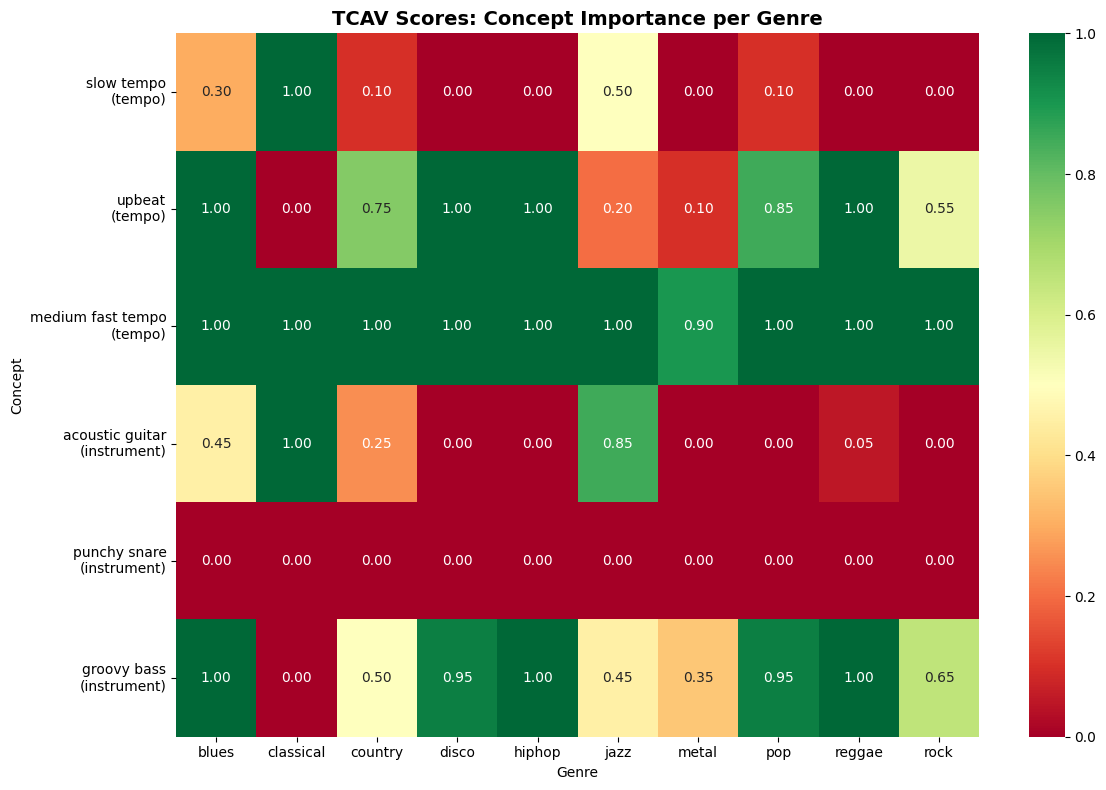

In [185]:
# Create TCAV scores heatmap
all_concepts = [c for concepts in ANALYSIS_CONCEPTS.values() for c in concepts]

# Build score matrix
score_matrix = []
concept_names = []

for category, concept_dict in results.items():
    for concept, data in concept_dict.items():
        scores = [data['genre_scores'].get(g, 0.0) for g in TARGET_GENRES]
        score_matrix.append(scores)
        concept_names.append(f"{concept}\n({category})")

score_matrix = np.array(score_matrix)

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    score_matrix, 
    xticklabels=TARGET_GENRES,
    yticklabels=concept_names,
    annot=True, 
    fmt='.2f',
    cmap='RdYlGn',
    vmin=0, vmax=1,
    ax=ax
)
ax.set_title('TCAV Scores: Concept Importance per Genre', fontsize=14, fontweight='bold')
ax.set_xlabel('Genre')
ax.set_ylabel('Concept')
plt.tight_layout()
plt.show()

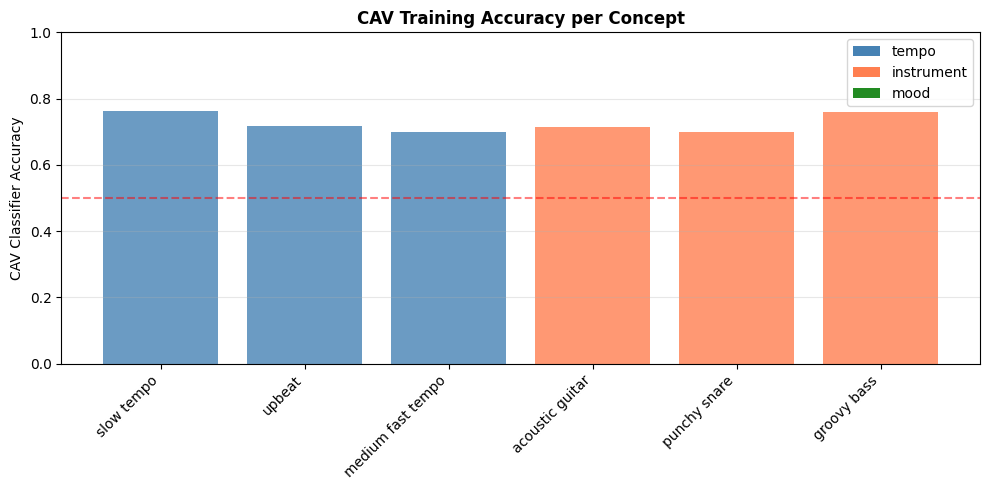

In [186]:
# Plot CAV classifier accuracies
fig, ax = plt.subplots(figsize=(10, 5))

accuracies = []
labels = []
colors = []
color_map = {'tempo': 'steelblue', 'instrument': 'coral', 'mood': 'forestgreen'}

for category, concept_dict in results.items():
    for concept, data in concept_dict.items():
        accuracies.append(data['cav_accuracy'])
        labels.append(concept)
        colors.append(color_map.get(category, 'gray'))

bars = ax.bar(range(len(accuracies)), accuracies, color=colors, alpha=0.8)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('CAV Classifier Accuracy')
ax.set_title('CAV Training Accuracy per Concept', fontweight='bold')
ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random baseline')
ax.set_ylim([0, 1])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add legend for categories
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=cat) for cat, c in color_map.items()]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Statistical Significance Testing with t-tests
from scipy import stats

print("\n" + "="*60)
print("STATISTICAL SIGNIFICANCE TESTING (t-tests)")
print("="*60)

# Perform statistical testing for each concept
significance_results = {}
genre_importance_results = {}

for category, concept_dict in results.items():
    print(f"\n📊 Category: {category.upper()}")
    print("-" * 40)
    
    for concept, data in concept_dict.items():
        print(f"\n  Concept: {concept}")
        print(f"  CAV Accuracy: {data['cav_accuracy']:.3f}")
        
        # Get TCAV scores across all genres
        tcav_scores = list(data['genre_scores'].values())
        
        # Hypothesis 1: TCAV scores are significantly different from random (0.5)
        t_stat_random, p_value_random = stats.ttest_1samp(tcav_scores, 0.5)
        
        print(f"  H0: TCAV scores = 0.5 (random)")
        print(f"    t-statistic: {t_stat_random:.4f}")
        print(f"    p-value: {p_value_random:.4e}")
        print(f"    Result: {'REJECT H0 ✓' if p_value_random < 0.05 else 'FAIL TO REJECT H0 ✗'}")
        print(f"    Mean TCAV: {np.mean(tcav_scores):.3f} ± {np.std(tcav_scores):.3f}")
        
        # Hypothesis 2: Compare concept activations vs random activations
        # Re-extract activations for statistical testing
        concept_data = create_concept_dataset_from_audio(concept, num_samples=num_samples)
        if concept_data is not None:
            concept_acts = tcav.get_activations(concept_data)
            random_acts_test = tcav.get_activations(random_data)
            
            # Get CAV for this concept
            cav = data.get('cav', results[category][concept].get('cav'))
            if cav is None:
                # Re-train CAV if not stored
                cav_result = tcav.train_cav(concept_acts, random_acts_test, num_runs=20)
                cav = cav_result['cav']
            else:
                # Extract from stored results
                cav = tcav.train_cav(concept_acts, random_acts_test, num_runs=1)['cav']
            
            # Compute projections onto CAV
            concept_projections = np.dot(concept_acts, cav)
            random_projections = np.dot(random_acts_test, cav)
            
            # Two-sample t-test: concept vs random projections
            t_stat_proj, p_value_proj = stats.ttest_ind(concept_projections, random_projections)
            
            print(f"\n  H0: Concept activations = Random activations")
            print(f"    t-statistic: {t_stat_proj:.4f}")
            print(f"    p-value: {p_value_proj:.4e}")
            print(f"    Result: {'REJECT H0 ✓' if p_value_proj < 0.05 else 'FAIL TO REJECT H0 ✗'}")
            print(f"    Concept mean: {np.mean(concept_projections):.3f}")
            print(f"    Random mean: {np.mean(random_projections):.3f}")
            print(f"    Effect size (Cohen's d): {(np.mean(concept_projections) - np.mean(random_projections)) / np.sqrt((np.std(concept_projections)**2 + np.std(random_projections)**2) / 2):.3f}")
        
        # Store results
        significance_results[f"{category}_{concept}"] = {
            'tcav_scores': tcav_scores,
            't_stat_random': t_stat_random,
            'p_value_random': p_value_random,
            'significant_vs_random': p_value_random < 0.05,
            'mean_tcav': np.mean(tcav_scores),
            'std_tcav': np.std(tcav_scores)
        }
        
        # Hypothesis 3: ANOVA across genres (are TCAV scores different across genres?)
        if len(tcav_scores) > 2:
            # Prepare data for ANOVA (need multiple samples per genre)
            genre_groups = []
            for genre_name in TARGET_GENRES:
                genre_idx = GENRE_MAP[genre_name]
                genre_mask = y_train == genre_idx
                genre_samples = X_train[genre_mask][:num_samples]
                genre_acts = tcav.get_activations(genre_samples)
                
                # Get individual TCAV scores
                genre_individual_scores = np.dot(genre_acts, cav)
                genre_groups.append(genre_individual_scores)
            
            # Perform one-way ANOVA
            f_stat, p_value_anova = stats.f_oneway(*genre_groups)

            genre_importance_results[f"{category}_{concept}"] = {
                'f_statistic': f_stat,
                'p_value_anova': p_value_anova,
                'significant_across_genres': p_value_anova < 0.05
            }
            
            print(f"\n  H0: TCAV scores are equal across all genres")
            print(f"    F-statistic: {f_stat:.4f}")
            print(f"    p-value: {p_value_anova:.4e}")
            print(f"    Result: {'REJECT H0 ✓' if p_value_anova < 0.05 else 'FAIL TO REJECT H0 ✗'}")
            print(f"    Interpretation: {'Concept has genre-specific importance' if p_value_anova < 0.05 else 'Concept importance is similar across genres'}")

print("\n" + "="*60)
print("✓ Statistical testing complete")


STATISTICAL SIGNIFICANCE TESTING (t-tests)

📊 Category: TEMPO
----------------------------------------

  Concept: slow tempo
  CAV Accuracy: 0.763
  H0: TCAV scores = 0.5 (random)
    t-statistic: -2.9047
    p-value: 1.7460e-02
    Result: REJECT H0 ✓
    Mean TCAV: 0.200 ± 0.310

  H0: Concept activations = Random activations
    t-statistic: 3.0521
    p-value: 4.1326e-03
    Result: REJECT H0 ✓
    Concept mean: 2.477
    Random mean: -0.767
    Effect size (Cohen's d): 0.990

  H0: TCAV scores are equal across all genres
    F-statistic: 64.1675
    p-value: 7.3036e-53
    Result: REJECT H0 ✓
    Interpretation: Concept has genre-specific importance

  Concept: upbeat
  CAV Accuracy: 0.719
  H0: TCAV scores = 0.5 (random)
    t-statistic: 1.1318
    p-value: 2.8698e-01
    Result: FAIL TO REJECT H0 ✗
    Mean TCAV: 0.645 ± 0.384

  H0: Concept activations = Random activations
    t-statistic: 2.5654
    p-value: 1.4375e-02
    Result: REJECT H0 ✓
    Concept mean: 4.834
    Rand

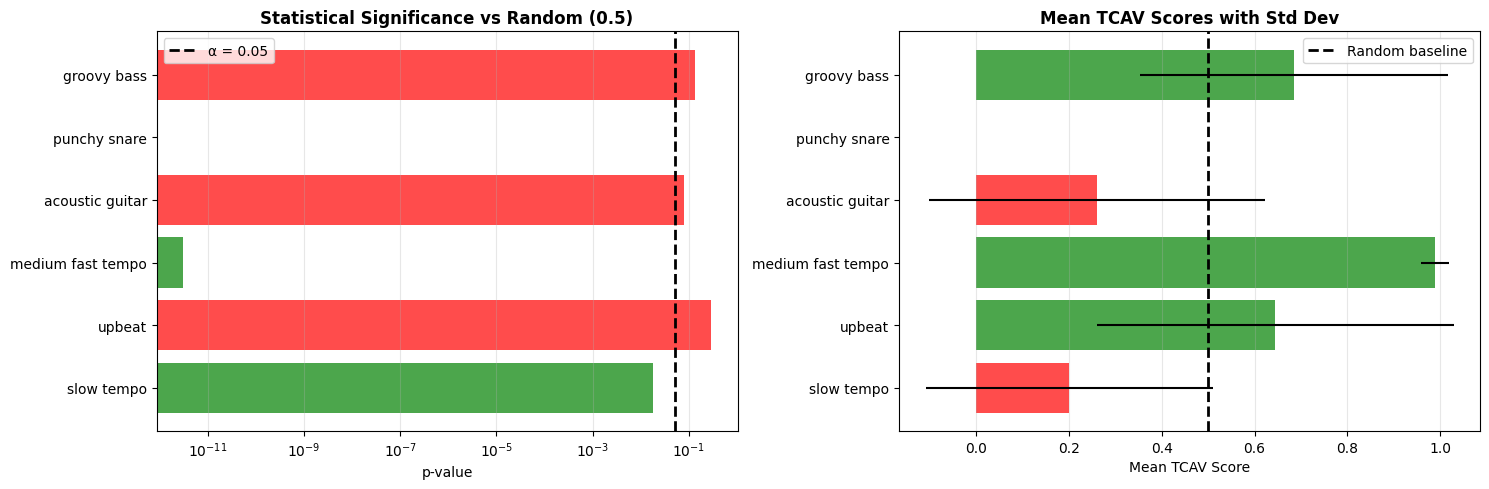


STATISTICAL SUMMARY TABLE
Concept              Mean TCAV    Std      p-value      Significant 
----------------------------------------------------------------------
slow tempo           0.200        0.310    1.7460e-02   ✓           
upbeat               0.645        0.384    2.8698e-01   ✗           
medium fast tempo    0.990        0.030    3.0793e-12   ✓           
acoustic guitar      0.260        0.362    7.8267e-02   ✗           
punchy snare         0.000        0.000    0.0000e+00   ✓           
groovy bass          0.685        0.333    1.3014e-01   ✗           


In [189]:
# Visualize statistical significance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: P-values for each concept
concepts_list = []
p_values_list = []
colors_sig = []

for concept_key, data in significance_results.items():
    concepts_list.append(concept_key.split('_', 1)[1])
    p_values_list.append(data['p_value_random'])
    colors_sig.append('green' if data['significant_vs_random'] else 'red')

axes[0].barh(range(len(concepts_list)), p_values_list, color=colors_sig, alpha=0.7)
axes[0].axvline(x=0.05, color='black', linestyle='--', linewidth=2, label='α = 0.05')
axes[0].set_yticks(range(len(concepts_list)))
axes[0].set_yticklabels(concepts_list)
axes[0].set_xlabel('p-value')
axes[0].set_title('Statistical Significance vs Random (0.5)', fontweight='bold')
axes[0].set_xscale('log')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Mean TCAV scores with confidence intervals
means = [data['mean_tcav'] for data in significance_results.values()]
stds = [data['std_tcav'] for data in significance_results.values()]

axes[1].barh(range(len(concepts_list)), means, xerr=stds, 
             color=['green' if m > 0.5 else 'red' for m in means], alpha=0.7)
axes[1].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Random baseline')
axes[1].set_yticks(range(len(concepts_list)))
axes[1].set_yticklabels(concepts_list)
axes[1].set_xlabel('Mean TCAV Score')
axes[1].set_title('Mean TCAV Scores with Std Dev', fontweight='bold')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*60)
print("STATISTICAL SUMMARY TABLE")
print("="*60)
print(f"{'Concept':<20} {'Mean TCAV':<12} {'Std':<8} {'p-value':<12} {'Significant':<12}")
print("-" * 70)

for concept_key, data in significance_results.items():
    concept_name = concept_key.split('_', 1)[1]
    sig_marker = '✓' if data['significant_vs_random'] else '✗'
    print(f"{concept_name:<20} {data['mean_tcav']:<12.3f} {data['std_tcav']:<8.3f} "
          f"{data['p_value_random']:<12.4e} {sig_marker:<12}")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
# Histogram of p-values
p_values = [data['p_value_random'] for data in significance_results.values()]
ax.hist(p_values, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
ax.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
ax.set_xlabel('p-value')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of p-values from TCAV Significance Tests', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Visualise genre-specific importance
fig, ax = plt.subplots(figsize=(10, 6))
# Histogram of p-values from ANOVA tests
anova_p_values = [data['p_value_anova'] for data in genre_importance_results.values()]
ax.hist(anova_p_values, bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
ax.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
ax.set_xlabel('p-value')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of p-values from Genre-Specific Importance Tests', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

In [187]:
# Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

for category, concept_dict in results.items():
    print(f"\n{category.upper()}:")
    for concept, data in concept_dict.items():
        scores = list(data['genre_scores'].values())
        print(f"  {concept}:")
        print(f"    CAV Accuracy: {data['cav_accuracy']:.3f}")
        print(f"    TCAV Score Range: [{min(scores):.3f}, {max(scores):.3f}]")
        print(f"    Mean TCAV Score: {np.mean(scores):.3f}")


SUMMARY STATISTICS

TEMPO:
  slow tempo:
    CAV Accuracy: 0.763
    TCAV Score Range: [0.000, 1.000]
    Mean TCAV Score: 0.200
  upbeat:
    CAV Accuracy: 0.719
    TCAV Score Range: [0.000, 1.000]
    Mean TCAV Score: 0.645
  medium fast tempo:
    CAV Accuracy: 0.700
    TCAV Score Range: [0.900, 1.000]
    Mean TCAV Score: 0.990

INSTRUMENT:
  acoustic guitar:
    CAV Accuracy: 0.713
    TCAV Score Range: [0.000, 1.000]
    Mean TCAV Score: 0.260
  punchy snare:
    CAV Accuracy: 0.700
    TCAV Score Range: [0.000, 0.000]
    Mean TCAV Score: 0.000
  groovy bass:
    CAV Accuracy: 0.760
    TCAV Score Range: [0.000, 1.000]
    Mean TCAV Score: 0.685
